In [23]:
# Install necessary libraries
!pip install torch numpy pandas scikit-learn matplotlib imblearn

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.feature_selection import SelectKBest, f_classif
from torch.utils.data import TensorDataset, DataLoader
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

In [26]:
# Load and explore the data
data = pd.read_csv("/content/loan_data.csv")

# Data quality checks and handling missing values
print(f"Original shape: {data.shape}")
print(f"Missing values:\n{data.isnull().sum()}")

# Fill missing values if any
for col in data.columns:
    if data[col].dtype in ['int64', 'float64']:
        data[col] = data[col].fillna(data[col].median())
    else:
        data[col] = data[col].fillna(data[col].mode()[0])

# Feature Engineering
# Create new features
if 'person_age' in data.columns and 'person_income' in data.columns:
    data['income_per_age'] = data['person_income'] / (data['person_age'] + 1)

if 'loan_amnt' in data.columns and 'person_income' in data.columns:
    data['loan_to_income_ratio'] = data['loan_amnt'] / (data['person_income'] + 1)

if 'loan_int_rate' in data.columns and 'loan_amnt' in data.columns:
    data['total_interest'] = data['loan_int_rate'] * data['loan_amnt'] / 100

if 'loan_percent_income' in data.columns:
    data['log_percent_income'] = np.log1p(data['loan_percent_income'])

Original shape: (45000, 14)
Missing values:
person_age                        0
person_gender                     0
person_education                  0
person_income                     0
person_emp_exp                    0
person_home_ownership             0
loan_amnt                         0
loan_intent                       0
loan_int_rate                     0
loan_percent_income               0
cb_person_cred_hist_length        0
credit_score                      0
previous_loan_defaults_on_file    0
loan_status                       0
dtype: int64


In [27]:
# Enhanced preprocessing
# Convert categorical variables with more informative encoding
cat_columns = data.select_dtypes(include=['object']).columns

# Apply get_dummies with improved strategy
data = pd.get_dummies(
    data,
    columns=["person_gender", "person_education", "person_home_ownership", "loan_intent", "previous_loan_defaults_on_file"],
    drop_first=True
)

# Define features & target
X = data.drop(columns=["loan_status"])
y = data["loan_status"].values

# Feature selection - Select most informative features
selector = SelectKBest(f_classif, k='all')
X_new = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]
X = X[selected_features]

print(f"Features after selection: {X.shape[1]}")

Features after selection: 26


In [28]:
# Train-test-validation split with better stratification
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Apply SMOTE to handle class imbalance (only on training data)
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Better scaling - PowerTransformer for better handling of skewed features
pt = PowerTransformer()
X_train_scaled = pt.fit_transform(X_train_smote)
X_val_scaled = pt.transform(X_val)
X_test_scaled = pt.transform(X_test)

# Convert to tensors
X_train, y_train = torch.tensor(X_train_scaled, dtype=torch.float32), torch.tensor(y_train_smote, dtype=torch.long)
X_val, y_val = torch.tensor(X_val_scaled, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long)
X_test, y_test = torch.tensor(X_test_scaled, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long)

In [29]:
# Improved DataLoader with better batch size
batch_size = 32  # Smaller batch size for better generalization
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

In [30]:
# Keep the Lorentzian Neural Network as requested
class LorentzianNN(nn.Module):
    def __init__(self, input_dim):
        super(LorentzianNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.fc4 = nn.Linear(32, 16)
        self.fc5 = nn.Linear(16, 2)

        self.dropout = nn.Dropout(0.3)

    def lorentzian_activation(self, x):
        return 1 / (1 + x ** 2)

    def forward(self, x):
        x = self.lorentzian_activation(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.lorentzian_activation(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.lorentzian_activation(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = self.lorentzian_activation(self.fc4(x))
        x = self.fc5(x)
        return x

In [31]:
# Set up device and model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create an ensemble of models
num_models = 3
models = []

for i in range(num_models):
    model = LorentzianNN(input_dim=X_train.shape[1]).to(device)
    models.append(model)

Using device: cuda


In [32]:
# Enhanced training process with better optimization
def train_model(model_idx, model, train_loader, val_loader):
    # Improved optimizer with better learning rate
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

    # Better scheduler for learning rate decay
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=2, verbose=True
    )

    # Use focal loss to handle imbalance better
    class FocalLoss(nn.Module):
        def __init__(self, alpha=0.25, gamma=2):
            super(FocalLoss, self).__init__()
            self.alpha = alpha
            self.gamma = gamma
            self.ce = nn.CrossEntropyLoss(reduction='none')

        def forward(self, inputs, targets):
            ce_loss = self.ce(inputs, targets)
            pt = torch.exp(-ce_loss)
            loss = self.alpha * (1-pt)**self.gamma * ce_loss
            return loss.mean()

    criterion = FocalLoss()

    num_epochs = 30
    best_val_loss = float("inf")
    patience, patience_counter = 5, 0

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(1, num_epochs + 1):
        model.train()
        train_loss, train_correct, total_train = 0, 0, 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()

            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            train_loss += loss.item() * X_batch.size(0)
            train_correct += (output.argmax(dim=1) == y_batch).sum().item()
            total_train += X_batch.size(0)

        train_loss /= total_train
        train_acc = train_correct / total_train
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        model.eval()
        val_loss, val_correct, total_val = 0, 0, 0

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                output = model(X_batch)
                loss = criterion(output, y_batch)

                val_loss += loss.item() * X_batch.size(0)
                val_correct += (output.argmax(dim=1) == y_batch).sum().item()
                total_val += X_batch.size(0)

        val_loss /= total_val
        val_acc = val_correct / total_val
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"Model {model_idx+1} - Epoch {epoch}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        # Use validation loss for scheduler
        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f"best_model_{model_idx}.pth")
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Model {model_idx+1} - Early stopping triggered!")
                break

    # Load the best model
    model.load_state_dict(torch.load(f"best_model_{model_idx}.pth"))
    return train_losses, val_losses, train_accs, val_accs

In [33]:
# Train each model in the ensemble
all_train_losses = []
all_val_losses = []
all_train_accs = []
all_val_accs = []

for i, model in enumerate(models):
    print(f"Training model {i+1}/{num_models}")
    train_losses, val_losses, train_accs, val_accs = train_model(i, model, train_loader, val_loader)
    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)
    all_train_accs.append(train_accs)
    all_val_accs.append(val_accs)

Training model 1/3


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Model 1 - Epoch 1/30 | Train Loss: 0.0438 | Train Acc: 0.5008 | Val Loss: 0.0451 | Val Acc: 0.2222
Model 1 - Epoch 2/30 | Train Loss: 0.0435 | Train Acc: 0.5020 | Val Loss: 0.0431 | Val Acc: 0.6800
Model 1 - Epoch 3/30 | Train Loss: 0.0434 | Train Acc: 0.4999 | Val Loss: 0.0420 | Val Acc: 0.7778
Model 1 - Epoch 4/30 | Train Loss: 0.0434 | Train Acc: 0.4952 | Val Loss: 0.0432 | Val Acc: 0.6068
Model 1 - Epoch 5/30 | Train Loss: 0.0434 | Train Acc: 0.4997 | Val Loss: 0.0407 | Val Acc: 0.7778
Model 1 - Epoch 6/30 | Train Loss: 0.0434 | Train Acc: 0.5024 | Val Loss: 0.0436 | Val Acc: 0.2277
Model 1 - Epoch 7/30 | Train Loss: 0.0434 | Train Acc: 0.5028 | Val Loss: 0.0426 | Val Acc: 0.7751
Model 1 - Epoch 8/30 | Train Loss: 0.0433 | Train Acc: 0.5148 | Val Loss: 0.0423 | Val Acc: 0.6659
Model 1 - Epoch 9/30 | Train Loss: 0.0361 | Train Acc: 0.6984 | Val Loss: 0.0252 | Val Acc: 0.8929
Model 1 - Epoch 10/30 | Train Loss: 0.0247 | Train Acc: 0.8523 | Val Loss: 0.0224 | Val Acc: 0.8719
Model 1 -

<ipython-input-32-1d2921a8cd3b>:94: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"best_model_{model_idx}.pth"))


Model 2 - Epoch 1/30 | Train Loss: 0.0436 | Train Acc: 0.5005 | Val Loss: 0.0458 | Val Acc: 0.2222
Model 2 - Epoch 2/30 | Train Loss: 0.0435 | Train Acc: 0.4989 | Val Loss: 0.0451 | Val Acc: 0.2221
Model 2 - Epoch 3/30 | Train Loss: 0.0435 | Train Acc: 0.5012 | Val Loss: 0.0409 | Val Acc: 0.7778
Model 2 - Epoch 4/30 | Train Loss: 0.0434 | Train Acc: 0.5020 | Val Loss: 0.0468 | Val Acc: 0.2222
Model 2 - Epoch 5/30 | Train Loss: 0.0434 | Train Acc: 0.4994 | Val Loss: 0.0437 | Val Acc: 0.2360
Model 2 - Epoch 6/30 | Train Loss: 0.0434 | Train Acc: 0.4952 | Val Loss: 0.0428 | Val Acc: 0.7640
Model 2 - Epoch 7/30 | Train Loss: 0.0434 | Train Acc: 0.4999 | Val Loss: 0.0429 | Val Acc: 0.7609
Model 2 - Epoch 8/30 | Train Loss: 0.0434 | Train Acc: 0.5023 | Val Loss: 0.0428 | Val Acc: 0.7711
Model 2 - Early stopping triggered!
Training model 3/3
Model 3 - Epoch 1/30 | Train Loss: 0.0437 | Train Acc: 0.5017 | Val Loss: 0.0431 | Val Acc: 0.6159
Model 3 - Epoch 2/30 | Train Loss: 0.0435 | Train Acc:

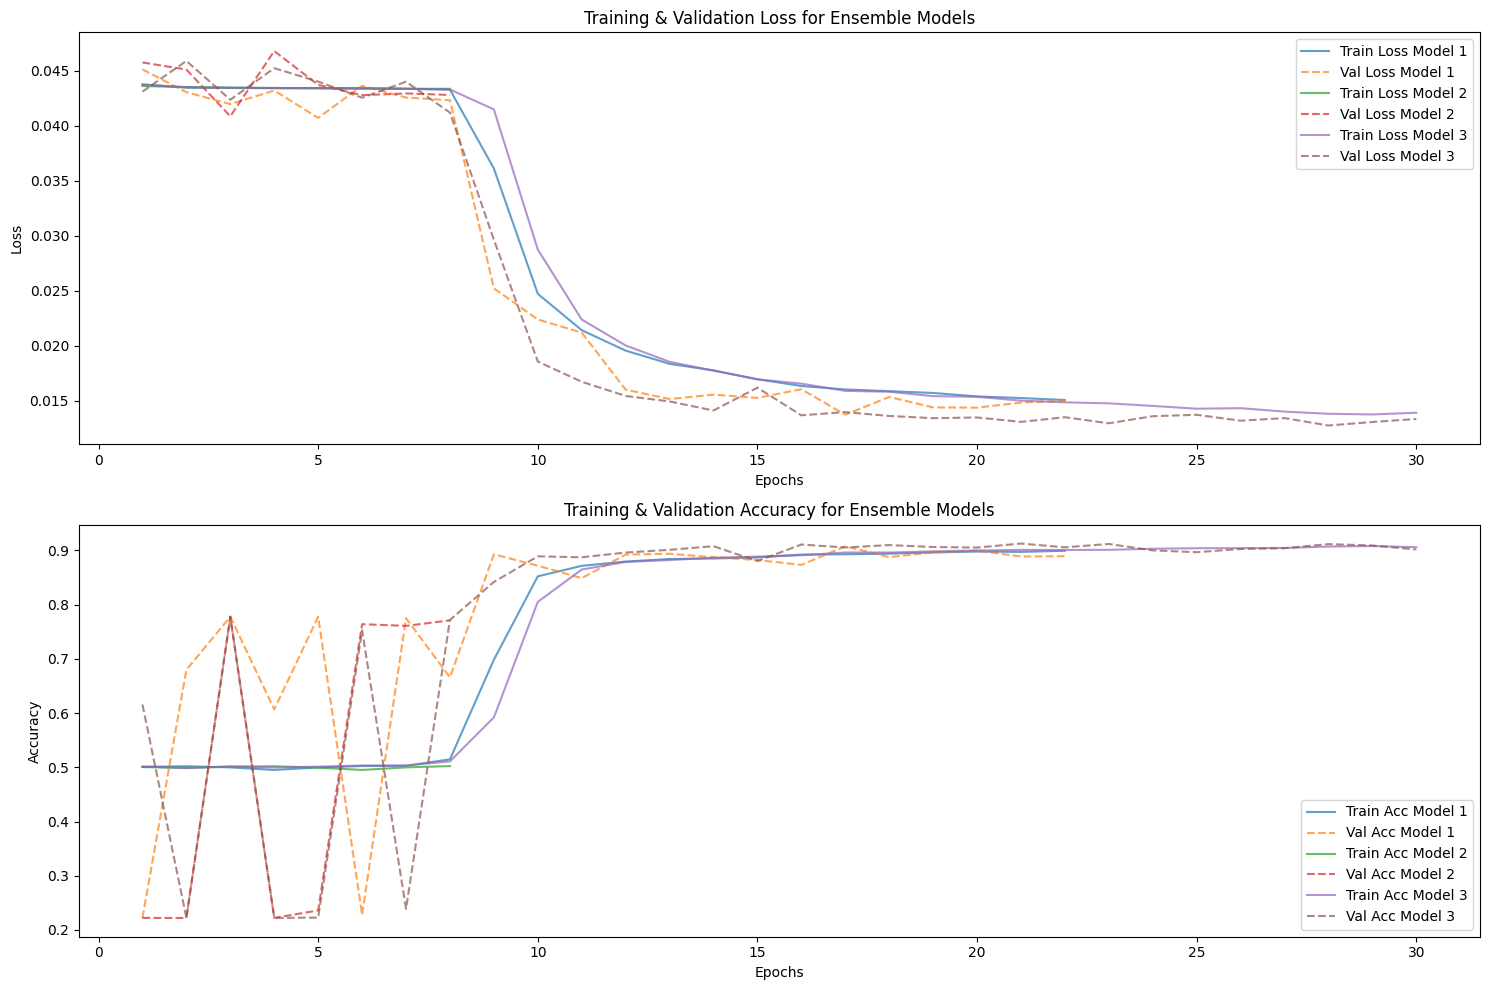

In [34]:
# Function to plot training curves for ensemble
def plot_ensemble_curves(all_train_losses, all_val_losses, all_train_accs, all_val_accs):
    plt.figure(figsize=(15, 10))

    # Plot losses
    plt.subplot(2, 1, 1)
    for i, (train_losses, val_losses) in enumerate(zip(all_train_losses, all_val_losses)):
        epochs = range(1, len(train_losses) + 1)
        plt.plot(epochs, train_losses, '-', label=f'Train Loss Model {i+1}', alpha=0.7)
        plt.plot(epochs, val_losses, '--', label=f'Val Loss Model {i+1}', alpha=0.7)

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss for Ensemble Models')
    plt.legend()

    # Plot accuracies
    plt.subplot(2, 1, 2)
    for i, (train_accs, val_accs) in enumerate(zip(all_train_accs, all_val_accs)):
        epochs = range(1, len(train_accs) + 1)
        plt.plot(epochs, train_accs, '-', label=f'Train Acc Model {i+1}', alpha=0.7)
        plt.plot(epochs, val_accs, '--', label=f'Val Acc Model {i+1}', alpha=0.7)

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training & Validation Accuracy for Ensemble Models')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the training curves
plot_ensemble_curves(all_train_losses, all_val_losses, all_train_accs, all_val_accs)

In [35]:
# Test the ensemble model
def test_ensemble(models, test_loader, device):
    for i, model in enumerate(models):
        model.eval()
        model.load_state_dict(torch.load(f"best_model_{i}.pth"))

    test_correct, total_test = 0, 0
    all_preds = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Get predictions from each model
            batch_preds = []
            for model in models:
                output = model(X_batch)
                batch_preds.append(output)

            # Average the predictions (soft voting)
            ensemble_output = torch.mean(torch.stack([p for p in batch_preds]), dim=0)
            predicted = ensemble_output.argmax(dim=1)

            test_correct += (predicted == y_batch).sum().item()
            total_test += X_batch.size(0)

            all_preds.append(predicted.cpu().numpy())

    test_acc = test_correct / total_test
    print(f"Ensemble Test Accuracy: {test_acc:.6f} ({test_correct}/{total_test})")

    return test_acc, all_preds

ensemble_acc, _ = test_ensemble(models, test_loader, device)

<ipython-input-35-ee543f392175>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"best_model_{i}.pth"))


Ensemble Test Accuracy: 0.911111 (6150/6750)


<ipython-input-36-f51d537225d4>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"best_model_{i}.pth"))


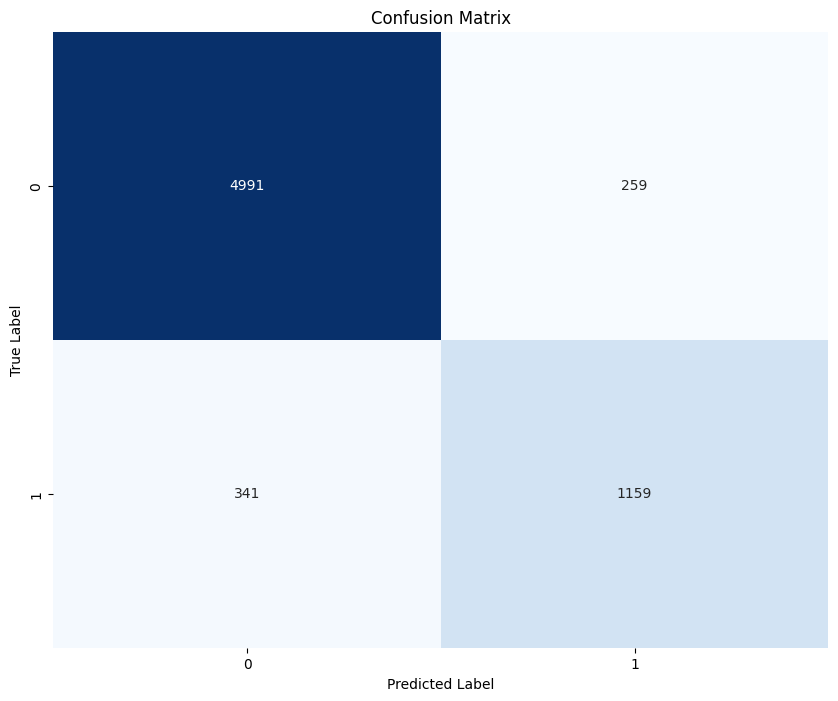

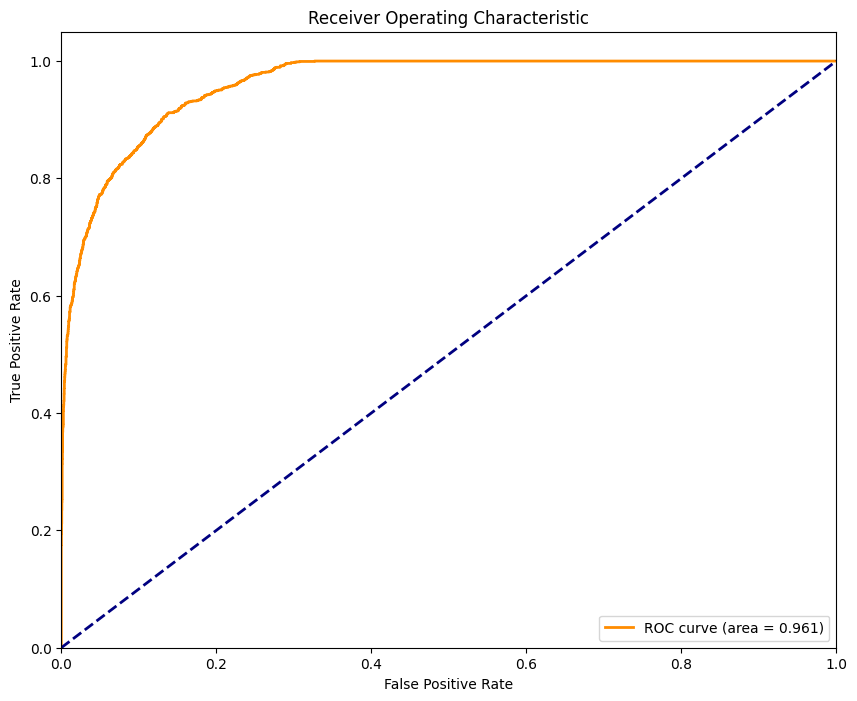


Classification Report:
Class 0:
  Precision: 0.9360
  Recall: 0.9507
  F1-score: 0.9433
  Support: 5250.0
Class 1:
  Precision: 0.8173
  Recall: 0.7727
  F1-score: 0.7944
  Support: 1500.0

Accuracy: 0.9111

Final Ensemble Accuracy: 0.9111


In [36]:
# Visualization of model performance
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns

def evaluate_model_performance(models, X_test, y_test, device):
    for i, model in enumerate(models):
        model.eval()
        model.load_state_dict(torch.load(f"best_model_{i}.pth"))

    # Get predictions
    all_outputs = []
    with torch.no_grad():
        X_test_device = X_test.to(device)
        for model in models:
            outputs = model(X_test_device)
            all_outputs.append(outputs)

        # Average outputs for ensemble
        ensemble_output = torch.mean(torch.stack([p for p in all_outputs]), dim=0)
        _, predicted = torch.max(ensemble_output, 1)
        probabilities = torch.nn.functional.softmax(ensemble_output, dim=1)

    # Convert to numpy for sklearn metrics
    y_pred = predicted.cpu().numpy()
    y_true = y_test.cpu().numpy()
    probs = probabilities[:, 1].cpu().numpy()  # Probability of positive class

    # Calculate metrics
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, output_dict=True)

    # Calculate ROC
    fpr, tpr, _ = roc_curve(y_true, probs)
    roc_auc = auc(fpr, tpr)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Plot ROC curve
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # Print classification report
    print("\nClassification Report:")
    for label, metrics in report.items():
        if label in ['0', '1']:
            print(f"Class {label}:")
            print(f"  Precision: {metrics['precision']:.4f}")
            print(f"  Recall: {metrics['recall']:.4f}")
            print(f"  F1-score: {metrics['f1-score']:.4f}")
            print(f"  Support: {metrics['support']}")

    print(f"\nAccuracy: {report['accuracy']:.4f}")

    return report['accuracy']

# Evaluate ensemble performance
final_accuracy = evaluate_model_performance(models, X_test, y_test, device)
print(f"\nFinal Ensemble Accuracy: {final_accuracy:.4f}")

In [37]:
# Save final ensemble model for production
def save_ensemble_model(models):
    ensemble_models = []
    for i, model in enumerate(models):
        model.load_state_dict(torch.load(f"best_model_{i}.pth"))
        ensemble_models.append(model.state_dict())

    # Save the whole ensemble
    torch.save({
        'models': ensemble_models,
        'feature_names': list(selected_features),
        'scaler': pt,
    }, 'loan_approval_ensemble_model.pth')

    print("Ensemble model saved successfully!")

save_ensemble_model(models)

Ensemble model saved successfully!


<ipython-input-37-35824f4bc225>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"best_model_{i}.pth"))


In [39]:
# Function for making predictions on new data
def predict_loan_approval(new_data, model_path='loan_approval_ensemble_model.pth'):
    # Load the model
    ensemble_data = torch.load(model_path)
    ensemble_models = ensemble_data['models']
    feature_names = ensemble_data['feature_names']
    scaler = ensemble_data['scaler']

    # Ensure the data has all necessary features
    for feature in feature_names:
        if feature not in new_data.columns:
            new_data[feature] = 0  # Default value if missing

    # Use only selected features in the right order
    new_data = new_data[feature_names]

    # Scale the data
    scaled_data = scaler.transform(new_data)

    # Convert to tensor
    X = torch.tensor(scaled_data, dtype=torch.float32).to(device)

    # Initialize models
    loaded_models = []
    for i, state_dict in enumerate(ensemble_models):
        model = LorentzianNN(input_dim=len(feature_names)).to(device)
        model.load_state_dict(state_dict)
        model.eval()
        loaded_models.append(model)

    # Make predictions
    all_outputs = []
    with torch.no_grad():
        for model in loaded_models:
            outputs = model(X)
            all_outputs.append(outputs)

        # Average outputs for ensemble
        ensemble_output = torch.mean(torch.stack([p for p in all_outputs]), dim=0)
        probabilities = torch.nn.functional.softmax(ensemble_output, dim=1)
        _, predictions = torch.max(ensemble_output, 1)

    # Convert to numpy
    predictions = predictions.cpu().numpy()
    prob_approve = probabilities[:, 1].cpu().numpy()

    return predictions, prob_approve